<a href="https://colab.research.google.com/github/panik-79/arxiv_paper_recommendation_model/blob/main/minor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook Perform two things...........

# 1 Section:                                                                 
Research Area Subject Area Prediction (Large Scale classification) using shallow Multi-Layer Perceptron (MLP) model

# 2 Section:
Research Paper Recommendation for reading: using sentence transformer model

Research Papers dataset link::
https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/data


# 1 Section:                                                                 

# Loading tools and dataset

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import csv
from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
arxiv_data = pd.read_csv("arxiv_data_210930-054931.csv")

In [ ]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


# Data Cleaning and Preprocessing

In [ ]:
arxiv_data.shape

(56181, 3)

In [ ]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [ ]:
arxiv_data.duplicated().sum()

15054

In [ ]:
arxiv_data["terms"]

0                                          ['cs.LG']
1                                 ['cs.LG', 'cs.AI']
2                      ['cs.LG', 'cs.CR', 'stat.ML']
3                                 ['cs.LG', 'cs.CR']
4                                          ['cs.LG']
                            ...                     
56176                             ['cs.CV', 'cs.IR']
56177    ['cs.LG', 'cs.AI', 'cs.CL', 'I.2.6; I.2.7']
56178                                      ['cs.LG']
56179                ['stat.ML', 'cs.LG', 'math.OC']
56180                  ['cs.LG', 'cs.AI', 'stat.ML']
Name: terms, Length: 56181, dtype: object

In [ ]:
# getting unique labels
labels_column = arxiv_data["terms"].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [ ]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [ ]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [ ]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

# train and test split.

In [ ]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

train_df["terms"]

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


3843            [cs.LG, stat.ML]
49212           [cs.LG, stat.ML]
23801                    [cs.CV]
5627                     [cs.CV]
19457                    [cs.CV]
                  ...           
41969                    [cs.CV]
40731                    [cs.CV]
16190    [cs.LG, cs.AI, stat.ML]
48609           [stat.ML, cs.LG]
7676       [cs.LG, cs.AI, cs.MA]
Name: terms, Length: 34741, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess train_df["terms"] by joining the individual strings in each list
terms_strings = train_df["terms"].apply(lambda x: ' '.join(x))

# Create a CountVectorizer object
vectorizer = CountVectorizer(binary=True, token_pattern=r'\b\w+\b')

# Fit the vectorizer to the preprocessed terms and transform them into a binary bag-of-words representation
X_train = vectorizer.fit_transform(terms_strings)

# Retrieve vocabulary
vocab = vectorizer.get_feature_names_out()

print("Vocabulary:\n")
print(vocab)


Vocabulary:

['0' '1' '10' '14f05' '14j26' '14j60' '2' '3' '4' '5' '6' '60l10' '60l20'
 '62h30' '62h35' '62h99' '65d19' '68' '68q32' '68t01' '68t05' '68t07'
 '68t10' '68t30' '68t45' '68t99' '68txx' '68u01' '68u10' '7' '8' '9' 'ai'
 'an' 'ao' 'ap' 'app' 'ar' 'as' 'astro' 'at' 'bio' 'bm' 'cc' 'cd' 'ce'
 'cg' 'chem' 'cl' 'class' 'co' 'comp' 'cond' 'cp' 'cr' 'cs' 'cv' 'cy'
 'data' 'db' 'dc' 'dis' 'dl' 'dm' 'ds' 'dyn' 'e' 'ec' 'econ' 'eess' 'em'
 'et' 'ex' 'f' 'fa' 'fin' 'fl' 'flu' 'g' 'geo' 'gn' 'gr' 'gt' 'h' 'hc'
 'hep' 'i' 'im' 'ir' 'it' 'iv' 'j' 'k' 'lg' 'lo' 'ma' 'mat' 'math' 'me'
 'mech' 'med' 'ml' 'mm' 'mn' 'mp' 'ms' 'mtrl' 'na' 'nc' 'ne' 'ni' 'nlin'
 'nn' 'oc' 'optics' 'ot' 'pe' 'pf' 'ph' 'physics' 'pl' 'plasm' 'pm' 'pr'
 'primary' 'q' 'qm' 'quant' 'rm' 'ro' 'sc' 'sci' 'sd' 'se' 'secondary'
 'si' 'soc' 'soft' 'sp' 'st' 'stat' 'sy' 'th' 'to' 'tr']


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert list of labels to list of tuples for MultiLabelBinarizer
label_tuples = [tuple(label) for label in train_df["terms"]]

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to all labels and transform them into a binary representation
labels_binarized = mlb.fit_transform(label_tuples)

# Get the unique categories from MultiLabelBinarizer
unique_categories = mlb.classes_

# Print unique categories
print("Unique Categories:")
print(unique_categories)

# Print binarized representation
print("Label-binarized representation:")
print(labels_binarized)

label_tuples[0]

Unique Categories:
[' ' '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ';' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'Y' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'l' 'm' 'n' 'o' 'p'
 'q' 'r' 's' 't' 'u' 'x' 'y']
Label-binarized representation:
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


('c',
 ' ',
 ' ',
 ' ',
 's',
 ' ',
 ' ',
 ' ',
 '.',
 ' ',
 ' ',
 ' ',
 'L',
 ' ',
 ' ',
 ' ',
 'G',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 's',
 ' ',
 ' ',
 ' ',
 't',
 ' ',
 ' ',
 ' ',
 'a',
 ' ',
 ' ',
 ' ',
 't',
 ' ',
 ' ',
 ' ',
 '.',
 ' ',
 ' ',
 ' ',
 'M',
 ' ',
 ' ',
 ' ',
 'L')

In [ ]:
# Define parameters
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"

def make_dataset(dataframe, is_train=True):
    # Convert labels to a list of lists
    labels = dataframe["terms"].values.tolist()

    # Convert labels to binarized representation
    mlb = MultiLabelBinarizer()
    label_binarized = mlb.fit_transform(labels)

    # Create dataset of abstracts and binarized label sequences
    dataset = list(zip(dataframe["abstracts"].values, label_binarized))

    # Shuffle data for training dataset
    if is_train:
        np.random.shuffle(dataset)

    # Batch the dataset
    num_batches = len(dataset) // batch_size
    if len(dataset) % batch_size != 0:
        num_batches += 1
    batches = [dataset[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

    return batches

# Example usage:
train_batches = make_dataset(train_df, is_train=True)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
def invert_multi_hot(label):
    # Assuming the label is a binary array where 1 indicates presence and 0 indicates absence of a category
    return [unique_categories[i] for i, val in enumerate(label) if val == 1]

# Iterate through batches of the training dataset
for batch in train_batches:
    text_batch, label_batch = zip(*batch)  # Unpack batch into text_batch and label_batch
    # Iterate through samples in the batch
    for i, text in enumerate(text_batch[:5]):
        label = label_batch[i][None, ...]  # Convert label to 2D array
        print(f"Abstract: {text}")
        print(f"Label(s): {invert_multi_hot(label[0])}")
        print(" ")


Streaming output truncated to the last 5000 lines.
Meta-Sim2 proceeds by learning to sequentially sample rule expansions from a
given probabilistic scene grammar. Due to the discrete nature of the problem,
we use Reinforcement Learning to train our model, and design a feature space
divergence between our synthesized and target images that is key to successful
training. Experiments on a real driving dataset show that, without any
supervision, we can successfully learn to generate data that captures discrete
structural statistics of objects, such as their frequency, in real images. We
also show that this leads to downstream improvement in the performance of an
object detector trained on our generated dataset as opposed to other baseline
simulation methods. Project page:
https://nv-tlabs.github.io/meta-sim-structure/.
Label(s): [' ', '.', 'C', 'G', 'I', 'L', 'R', 'V', 'c', 'e', 's']
 
Abstract: Security, privacy, and fairness have become critical in the era of data
science and machine lea

In [ ]:
 # This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

158810


In [ ]:
train_dataset[1][0]

('While accelerators such as GPUs have limited memory, deep neural networks are\nbecoming larger and will not fit with the memory limitation of accelerators for\ntraining. We propose an approach to tackle this problem by rewriting the\ncomputational graph of a neural network, in which swap-out and swap-in\noperations are inserted to temporarily store intermediate results on CPU\nmemory. In particular, we first revise the concept of a computational graph by\ndefining a concrete semantics for variables in a graph. We then formally show\nhow to derive swap-out and swap-in operations from an existing graph and\npresent rules to optimize the graph. To realize our approach, we developed a\nmodule in TensorFlow, named TFLMS. TFLMS is published as a pull request in the\nTensorFlow repository for contributing to the TensorFlow community. With TFLMS,\nwe were able to train ResNet-50 and 3DUnet with 4.7x and 2x larger batch size,\nrespectively. In particular, we were able to train 3DUNet using im

# Text Vectorization

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Initialize a TextVectorization layer
text_vectorizer = TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

# Extract text data from all batches in the training set
texts = []
for batch in train_dataset:
    text_batch = batch[0]  # Extract text batch
    texts.extend(text_batch)  # Convert TensorFlow tensor to numpy array and extend the list
texts = [str(text) for text in texts]
# Adapt the TextVectorization layer using the text data
text_vectorizer.adapt(texts)


In [ ]:
import pandas as pd

# Flatten the lists in the "terms" column into strings
train_df['terms'] = train_df['terms'].apply(lambda x: ' '.join(x))
val_df['terms'] = val_df['terms'].apply(lambda x: ' '.join(x))
test_df['terms'] = test_df['terms'].apply(lambda x: ' '.join(x))

# Now train_df, val_df, and test_df have the "terms" column with strings instead of lists

# Now you can proceed with creating TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['abstracts'].values, train_df['terms'].values, train_df['titles'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['abstracts'].values, val_df['terms'].values, val_df['titles'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['abstracts'].values, test_df['terms'].values, test_df['titles'].values))


# model training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Convert the text data using TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=10000, output_mode='tf-idf')
text_vectorizer.adapt(train_df['abstracts'])

# Create shallow MLP model with single neuron output
model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer with single neuron
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])


Epoch 1/20


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-120-befe5871910d>", line 25, in <cell line: 25>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2521, in binary_crossentropy

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_9317]

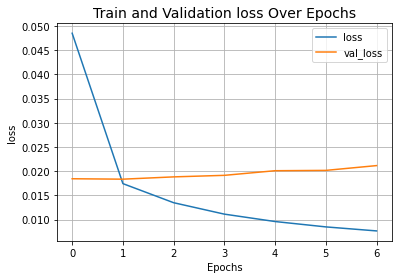

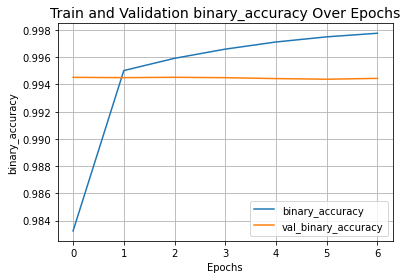

In [ ]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

# Model Evaluation

In [ ]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 [==============================] - 9s 559ms/step - loss: 0.0183 - binary_accuracy: 0.9945
Categorical accuracy on the test set: 99.46%.
Categorical accuracy on the validation set: 99.45%.


# Save Model and Text Vectorizer:

In [ ]:
# Save the model
model1.save("models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)


# Save the vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Load Model and Text Vectorizer:

In [ ]:
from tensorflow import keras
import pickle

# Load the model
loaded_model = keras.models.load_model("models/model.h5")

from tensorflow.keras.layers import TextVectorization

# Load the configuration of the text vectorizer
with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# Create a new TextVectorization layer with the saved configuration
loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

# Load the saved weights into the new TextVectorization layer
with open("models/text_vectorizer_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    loaded_text_vectorizer.set_weights(weights)


In [ ]:
# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)


# Model Prediction

In [ ]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [ ]:
def predict_category(abstract, model, vectorizer, label_lookup):
    # Preprocess the abstract using the loaded text vectorizer
    preprocessed_abstract = vectorizer([abstract])

    # Make predictions using the loaded model
    predictions = model.predict(preprocessed_abstract)

    # Convert predictions to human-readable labels
    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])

    return predicted_labels

In [ ]:
# Example usage
new_abstract = "Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations."
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)


1/1 [==============================] - 2s 2s/step
Predicted Categories: ['cs.LG']


In [ ]:
# Example usage
new_abstract = 'Deep networks and decision forests (such as random forests and gradient\nboosted trees) are the leading machine learning methods for structured and\ntabular data, respectively. Many papers have empirically compared large numbers\nof classifiers on one or two different domains (e.g., on 100 different tabular\ndata settings). However, a careful conceptual and empirical comparison of these\ntwo strategies using the most contemporary best practices has yet to be\nperformed. Conceptually, we illustrate that both can be profitably viewed as\n"partition and vote" schemes. Specifically, the representation space that they\nboth learn is a partitioning of feature space into a union of convex polytopes.\nFor inference, each decides on the basis of votes from the activated nodes.\nThis formulation allows for a unified basic understanding of the relationship\nbetween these methods. Empirically, we compare these two strategies on hundreds\nof tabular data settings, as well as several vision and auditory settings. Our\nfocus is on datasets with at most 10,000 samples, which represent a large\nfraction of scientific and biomedical datasets. In general, we found forests to\nexcel at tabular and structured data (vision and audition) with small sample\nsizes, whereas deep nets performed better on structured data with larger sample\nsizes. This suggests that further gains in both scenarios may be realized via\nfurther combining aspects of forests and networks. We will continue revising\nthis technical report in the coming months with updated results.'
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)

1/1 [==============================] - 0s 459ms/step
Predicted Categories: ['cs.LG' 'cs.AI']


In [ ]:
# great resutls...................................

# =======Section 2========

# 2 Recommendation System

In [8]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

In [9]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [10]:
pd.set_option('display.max_colwidth', None)
arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
41100,An experimental study of graph-based semi-supervised classification with additional node information
41101,Bayesian Differential Privacy through Posterior Sampling
41102,Mining Spatio-temporal Data on Industrialization from Historical Registries
41103,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


# Sentence Transformers

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import numpy as np
from scipy.spatial.distance import cosine
import pickle

nltk.download("punkt")
nltk.download("stopwords")

# Example sentences (assuming `arxiv_data` is defined)
sentences = arxiv_data["titles"]

# Tokenization and normalization
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
stop_words = set(stopwords.words('english'))
normalized_sentences = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in tokenized_sentences]

# Train Word2Vec model
word2vec_model = Word2Vec(normalized_sentences, vector_size=100, window=5, min_count=1, sg=1)

# Saving the Word2Vec model
with open('word2vec_model.pkl', 'wb') as f:
    pickle.dump(word2vec_model, f)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Function to generate sentence embeddings by averaging word embeddings
def sentence_embedding(sentence, model):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate sentence embeddings
all_sentence_embeddings = [sentence_embedding(sentence, word2vec_model) for sentence in normalized_sentences]


# Why select all-MiniLM-L6-v2?

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. Source

Its small in size 80 MB with good performance.

# Print the embeddings

In [29]:
# c = 0
# # Iterate over pairs of sentences and their corresponding embeddings
# for sentence, normalized_sentence in zip(sentences, normalized_sentences):
#     # Generate sentence embedding
#     vectors = []
#     for word in normalized_sentence:
#         if word in word2vec_model.wv:
#             vectors.append(word2vec_model.wv[word])
#     if vectors:
#         sentence_embedding = np.mean(vectors, axis=0)
#     else:
#         sentence_embedding = np.zeros(word2vec_model.vector_size)

#     # Print information
#     print("Sentence:", sentence)
#     print("Embedding length:", len(sentence_embedding)) # list of floats
#     print("")

#     # Break out of the loop after printing information for the first 5 sentences
#     if c >= 5:
#         break
#     c += 1

# Save files

In [30]:
# Saving sentences and corresponding embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(all_sentence_embeddings, f)

with open('sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)

# Recommendation for similar papers

In [31]:
# Load saved files
sentences = pickle.load(open('sentences.pkl','rb'))
word2vec_model = pickle.load(open('word2vec_model.pkl','rb'))
all_sentence_embeddings = pickle.load(open('embeddings.pkl','rb'))

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def recommendation(input_paper, embeddings, sentences):
    # Calculate embeddings for the input paper
    input_embedding = sentence_embedding(input_paper, word2vec_model)

    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = cosine_similarity([input_embedding], embeddings)[0]

    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers_indices = np.argsort(cosine_scores)[::-1][:5]

    # Retrieve the titles of the top similar papers.
    papers_list = [sentences[i] for i in top_similar_papers_indices]

    return papers_list

In [41]:
input_paper = "Neural Network"
input_paper_tokens = word_tokenize(input_paper.lower())
recommendations = recommendation(input_paper_tokens, all_sentence_embeddings, sentences)
print("Top 5 Recommended Papers:")
for i, paper in enumerate(recommendations, 1):
    print(f"{i}. {paper}")

Top 5 Recommended Papers:
1. A Neural Network for Semigroups
2. SGAD: Soft-Guided Adaptively-Dropped Neural Network
3. Neural Network Branch-and-Bound for Neural Network Verification
4. MGIC: Multigrid-in-Channels Neural Network Architectures
5. Which Minimizer Does My Neural Network Converge To?


In [42]:
import requests
from bs4 import BeautifulSoup

In [46]:
base_url = "https://arxiv.org/search/?query={}&searchtype=all&abstracts=show&order=-announced_date_first&size=50"

final_urls = []
titles = []
abstracts = []
for paper in recommendations:
    query = '+'.join(paper.split())
    url = base_url.format(query)
    web = requests.get(url)
    soup = BeautifulSoup(web.content,"html.parser")
    links = soup.find_all("p", attrs={'class':'list-title is-inline-block'})
    for i in range(len(links)):
      final_urls.append(links[i].find_all("a")[0].get('href'))

for i in range(len(final_urls)):
  web2 = requests.get(final_urls[i])
  soup2 = BeautifulSoup(web2.content,"html.parser")
  title = soup2.find("h1",attrs={'class':'title mathjax'}).text
  title=title.strip("Title").strip(':')
  titles.append(title)
  abstract = soup2.find('blockquote',attrs={'class':'abstract mathjax'})
  abstract=abstract.text.strip('\nAbstract:')
  abstracts.append(abstract)


In [47]:
len(titles)

41

In [ ]:
abstracts[-7]

'Motif discovery is gaining increasing attention in the domain of functional data analysis. Functional motifs are typical "shapes" or "patterns" that recur multiple times in different portions of a single curve and/or in misaligned portions of multiple curves. In this paper, we define functional motifs using an additive model and we propose funBIalign for their discovery and evaluation. Inspired by clustering and biclustering techniques, funBIalign is a multi-step procedure which uses agglomerative hierarchical clustering with complete linkage and a functional distance based on mean squared residue scores to discover functional motifs, both in a single curve (e.g., time series) and in a set of curves. We assess its performance and compare it to other recent methods through extensive simulations. Moreover, we use funBIalign for discovering motifs in two real-data case studies; one on food price inflation and one on temperature changes.\n    '

In [ ]:
final_urls[-1]

'https://arxiv.org/abs/2403.08011'